In [1091]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.constants as constants
import matplotlib
matplotlib.rcParams["figure.dpi"] = 300

In [1092]:
def runge_kutta4(f, delta_t, T, x0, force_func):
    '''Compute the solution of the ODE using the Runge-Kutta 4th order method.
    Parameters:
    -----------
    f : function
        The function that defines the ODE.
    delta_t : float
        The time step.
    T : float
        The final time.
    x0 : numpy.ndarray
        The initial condition.
    force_func : function
        The forces from the trail

    Returns:
    --------
    v : numpy.ndarray
        The solution of the ODE.
    t : numpy.ndarray
        The timesteps.
    '''

    '''We need this because we want to have fine control of the time steps. solve_ivp has dynamic time steps that
    have unpredictable behavior.'''

    # Initialize timesteps and solution
    t = np.linspace(0, T, int(np.floor(T / delta_t)) + 1)
    v = np.empty((np.shape(x0)[0], np.shape(t)[0]))
    v[:, 0] = x0

    # Compute the Runge-Kutta 4th order method
    for i in range(len(t)-1):
        k0 = f(t[i], v[:, i], force_func)
        k1 = f(t[i] + delta_t/2, v[:, i] + 0.5*delta_t*k0, force_func)
        k2 = f(t[i] + delta_t/2, v[:, i] + 0.5*delta_t*k1, force_func)
        k3 = f(t[i] + delta_t, v[:, i] + delta_t*k2, force_func)
        v[:, i+1] = v[:, i] + delta_t/6*(k0 + 2*k1 + 2*k2 + k3)
    return v, t

In [1093]:


class Shock:
    '''
    Class for representing a mountain bike shock and returning the ODE for the shock.

    Parameters:
    -----------
    config : dict
        The configuration of the shock.
    
        
    Attributes:
    -----------
    rider_mass : float
        The mass of the rider [kg].
    spring_type : str
        The type of spring used in the shock (coil or air).
    spring_constant : float
        The spring constant of the spring (used for coil spring) [N/m].
    initial_pressure : float
        The initial pressure of the air spring in Pascals [N/m^2].
    progression_tokens : float
        The progression tokens in the air spring to reduce shock volume. Each reduces the volume by 10cm^3 [m^3].
    stanchion_radius : float
        The radius of the stanchion of the shock. Usually 32, 34, 36, 38, or 40mm [m].
    travel_length : float
        The travel length of the shock. Ususally between 100mm and 230mm [m].
    initial_volume : float
        The initial volume of the air spring. Depends on stanchion radius and travel length [m^3].
    HSC_param : float
        The high speed compression damping parameter.
    LSC_param : float
        The low speed compression damping parameter.
    HSR_param : float
        The high speed rebound damping parameter.
    LSR_param : float
        The low speed rebound damping parameter.
    friction : float
        The friction in the shock.
    y0 : list
        The initial conditions of the ODE with the rider on the spring [m, m/s].

    Methods:
    --------
    get_model()
        Return the model of the ODE.
    model(t, y, f)
        The model of the ODE.
    get_y0()
        Return the initial conditions of the ODE.
    spring(t, y)
        Compute the total spring force.
    compute_airspring_force(y)
        Compute the air spring force.
    LSC(t, y, dy)
        Compute the low speed compression damping.
    HSC(t, y, dy)
        Compute the high speed compression damping.
    LSR(t, y, dy)
        Compute the low speed rebound damping.
    HSR(t, y, dy)
        Compute the high speed rebound damping.
    damping(t, y, dy)
        Compute the total damping force
    '''

    def __init__(self, config=None):
        '''
        Set parameters for the shock and compute necessary values.
        '''

        # Set parameters from shock configuration
        self.config = config
        self.rider_mass = config["rider_weight"]
        self.spring_type = config["spring_type"]
        self.spring_constant = config["spring_constant"]
        self.initial_pressure = config["initial_pressure"] * 6894.76 # Convert psi to Pa
        self.progression_tokens = config["progression_tokens"] * 8 * 1e-6 # Each volume token is 8cm^3 then convert to m^3
        self.stanchion_radius = config["stanchion_diameter"] / 2 * 1e-3 # Convert mm to m
        self.travel_length = config["travel_length"] * 1e-3 # Convert mm to m
        self.HSC_param = config["HSC"]
        self.LSC_param = config["LSC"]
        self.HSR_param = config["HSR"]
        self.LSR_param = config["LSR"]
        self.friction = config["friction"]

        # Compute the initial volume of the air spring
        self.initial_volume = np.pi * (self.stanchion_radius)**2 * self.travel_length - self.progression_tokens       


        # Initial conditions for rider on the spring solved from Newton's second law
        self.y0 = None
        if self.spring_type == "coil":
            self.y0 = [self.rider_mass * constants.g / self.spring_constant, 0]
        elif self.spring_type == "air":
            self.y0 = [self.travel_length - self.initial_pressure * self.initial_volume / (self.rider_mass * constants.g), 0]
        if self.y0[0] < 0:
            self.y0[0] = 0.001

    def get_model(self):
        '''
        Return everything needed to solve the ODE.
        '''

        return self.model, self.get_y0()

    def model(self, t, y, f):
        '''
        The complete second order ODE for the shock
        '''
        return np.array([y[1], -self.spring(t, y[0]) -self.damping(y[1]) + f(t) + self.rider_mass * constants.g]) / self.rider_mass

    def get_y0(self):
        '''
        Return the initial conditions of the ODE.
        '''
        return np.array(self.y0)
    
    def spring(self, t, y):
        '''
        Compute the total spring force.
        '''

        # This is from Hooke's Law
        if self.spring_type == "coil":
            # Added mollifications to approximate Dirac forces on either end of the shock while still being smooth
            return self.spring_constant * (y + (y / (self.travel_length))**100 - (y / (self.travel_length)-1)**100)
        
        elif self.spring_type == "air":
            return self.compute_airspring_force(y)
        
    def compute_airspring_force(self, y):
        '''
        Compute the air spring force.
        '''

        # This can be derived from Boyle's Law
        # The mollification approximates the Dirac force on the uncompressed end of the shock
        val = self.initial_pressure * self.initial_volume / (self.travel_length - y) - np.exp(1-1000*(y/(self.travel_length+0.01)))
        return val
        
    '''
    Compression is only active when the shock is being compressed (dy > 0)
    Rebound is only active when the shock is being extended (dy < 0)
    The min / max functions ensure that we do not divide by zero or multiply by infinity
    '''

    def LSC(self, dy):
        '''
        Compute the low speed compression damping.
        '''
        if dy < 0:
            return 0
        return self.LSC_param / (1 + np.exp(-self.LSC_param * np.abs(dy))) - self.LSC_param / 2

    def HSC(self, dy):
        '''
        Compute the high speed compression damping.
        '''
        if dy < 0:
            return 0
        return np.sqrt(np.abs(dy)) * self.HSC_param
    
    def LSR(self, dy):
        '''
        Compute the low speed rebound damping.
        '''
        if dy > 0:
            return 0
        return -self.LSR_param / (1 + np.exp(-self.LSR_param * np.abs(dy))) + self.LSR_param / 2
    
    def HSR(self, dy):
        '''
        Compute the high speed rebound damping.
        '''
        if dy > 0:
            return 0
        return -np.sqrt(np.abs(dy)) * self.HSR_param

    def damping(self, dy):
        '''
        Compute the total damping force.
        '''
        return  self.LSC(dy) + self.HSC(dy) + self.LSR(dy) + self.HSR(dy) + self.friction 

    
    

In [1094]:

class Evaluator():
    '''
    Class for solving and evaluating the shock model with a given trail.

    Parameters:
    -----------
    shock : Shock
        The shock to evaluate.
    
    Attributes:
    -----------
    shock : Shock
        The shock to evaluate.
    sol : The solution of the ODE.
    t : The timesteps of the solution.
    '''

    def __init__(self, shock=None):
        '''Set Evaluator parameters.'''
        self.shock = shock
        self.sol = None

    def evaluate(self, trail, use_scipy=False):
        '''Evaluate the shock mode0l with a given trail.'''

        # Check if the shock is set
        if self.shock is None:
            raise ValueError("Shock is not set")
        trail_forces, t_eval, t_span = trail.get_trail()

        # Get the shock model and initial conditions
        model, y0 = self.shock.get_model()

        # Solve the ODE using scipy. This has adaptive time steps which can be unpredictable
        if use_scipy:
            sol = solve_ivp(model, t_span, y0, args=(trail_forces,), t_eval=t_eval)
            self.sol = sol.y0
            self.t = sol.t
            return self.t, self.sol
        
        # Solve using a fixed time step Runge-Kutta 4th order method (default)
        self.sol, self.t = runge_kutta4(model, 0.01, 100, y0, trail_forces)
        self.sol = self.sol[0, :]
        return self.t, self.sol
    
    def plot(self, trail=None, ax=None, title=""):
        '''Plot the solution of the ODE.'''

        # Check if the solution is set
        if self.sol is None and trail is None:
            raise ValueError("No solution to plot. Please specify a trail to evaluate")
        elif self.sol is None:
            self.evaluate(trail)

        # Plot the solution
        ax.plot(self.t, -self.sol, label="Shock Displacement")
        ax.set_xlim([0, self.t[-1]])

        # Plot the travel length of the shock
        ax.plot(self.t, -self.shock.travel_length * np.ones_like(self.t), label="Travel Length", linestyle="--", color="black")
        ax.plot(self.t, np.zeros_like(self.t), linestyle="--", color="black")
        ax.set_title(title)
    
        # Plot the trail forces (normalized to the travel length of the shock)
        trail_arr = trail.trail_func(self.t)
        ax.plot(self.t, trail_arr / max(trail_arr) * self.shock.travel_length - self.shock.travel_length, label="Trail Forces")
        ax.legend(loc="lower right")
        

In [1095]:
class Trail():
    def __init__(self, config=None):
        self.config = config
        self.length = config["duration"]
        self.t_eval = np.array(range(self.length))
        self.t_span = (0, self.length)
        self.forces = None

    def trail_func(self, t):
        # if type(t) == np.ndarray:
        #     return np.array([self.trail_func(i) for i in t])
        # else:
        #     return 0
        if type(t) == np.ndarray:
            return np.array([self.trail_func(i) for i in t])

        # if t < 50 : 
        #     return 1000*np.abs(np.sin(2*np.pi*t/100))
        # else:
        #     return 0


        return (50*np.abs(np.sin(t/10)) + 75*np.abs((np.cos(t/5))) + 2000 * np.abs((np.sin(t/20)))) 

    def create_trail(self):
        return self.trail_func
    
    def get_trail(self):
        if self.forces is None:
            self.forces = self.create_trail()
        return self.forces, self.t_eval, self.t_span

    

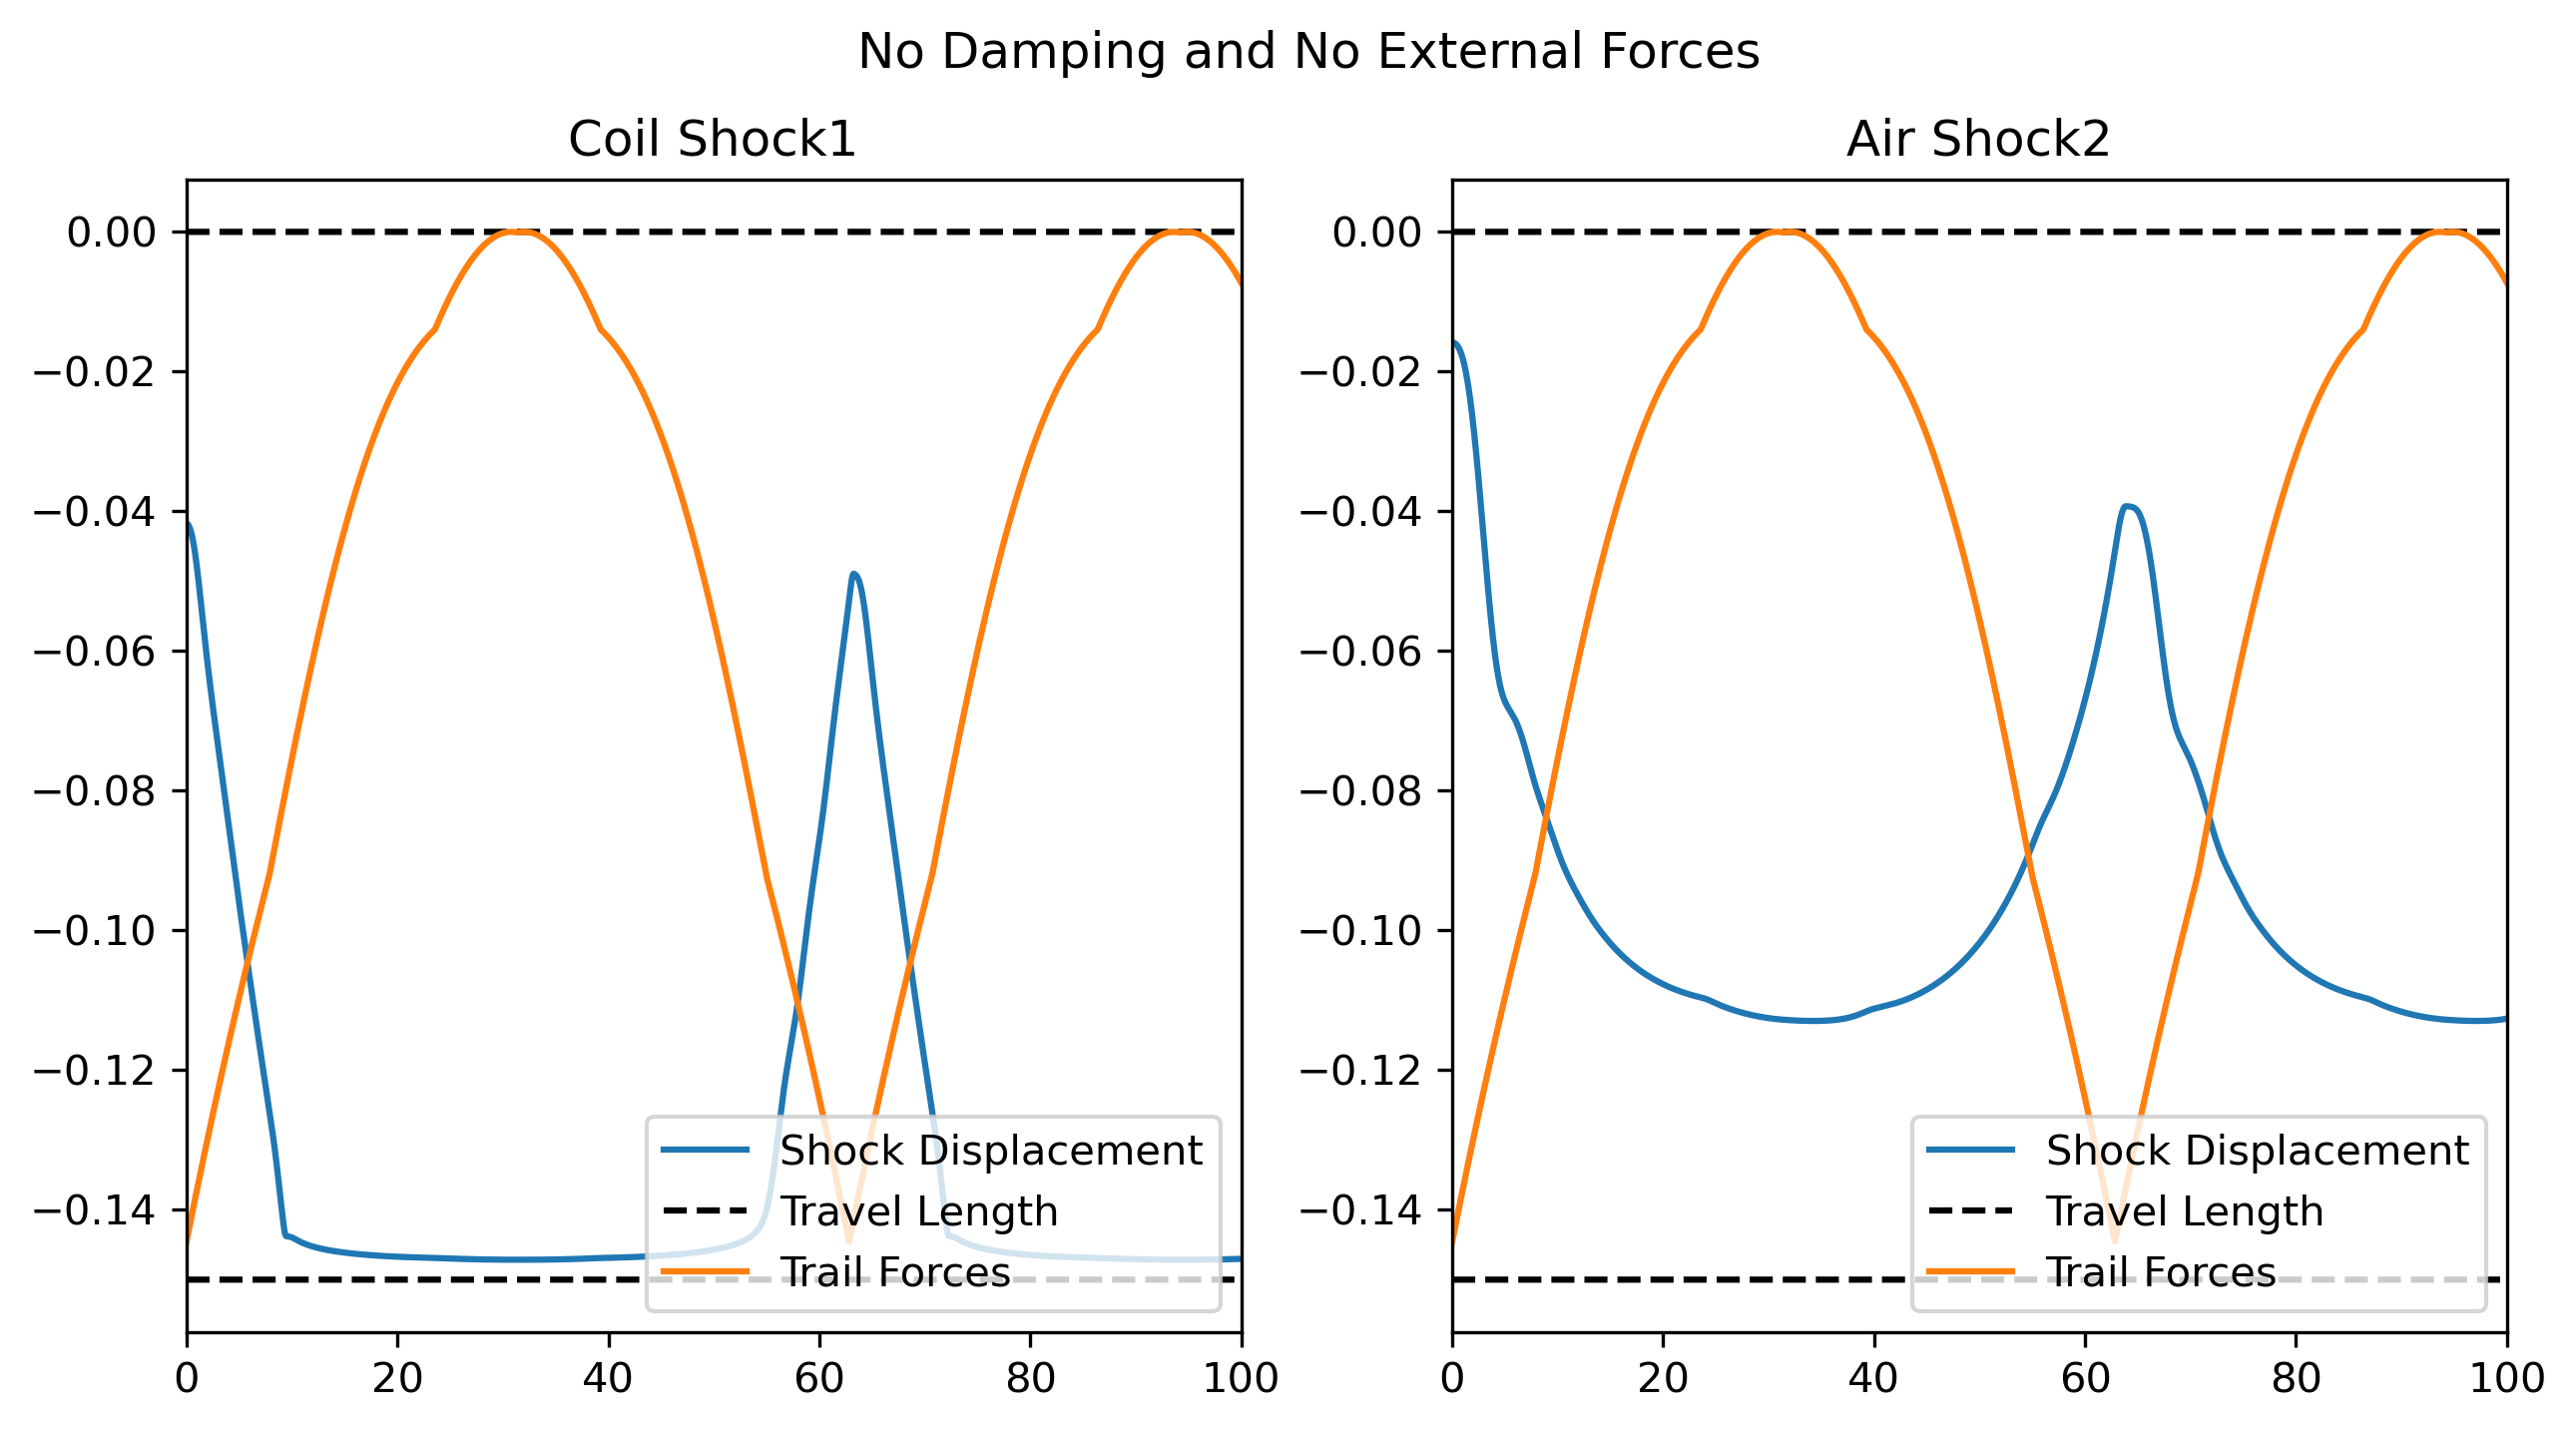

In [1096]:
shock_config1 = {
    "spring_type": "coil",
    "spring_constant": 8230.96, # 5 N/m
    "initial_pressure": 20,
    "rider_weight": 35, 
    "progression_tokens": 0,
    "stanchion_diameter": 36,
    "travel_length": 150,
    "HSC": 100,
    "LSC": 100,
    "HSR": 10,
    "LSR": 10,
    "friction": 0.1
}

shock_config2 = {
    "spring_type": "air",
    "spring_constant": 35, # 5 N/m
    "initial_pressure": 100,
    "rider_weight": 80, 
    "progression_tokens": 0,
    "stanchion_diameter": 36,
    "travel_length": 150,
    "HSC": 100,
    "LSC": 100,
    "HSR": 100,
    "LSR": 100,
    "friction": 0
}

trail_config = {
    "duration": 100
}

shock = Shock(shock_config1)
shock2 = Shock(shock_config2)
evaluator1 = Evaluator(shock)
evaluator2 = Evaluator(shock2)

trail = Trail(trail_config)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

evaluator1.plot(trail, ax[0], title="Coil Shock1")
evaluator2.plot(trail, ax[1], title="Air Shock2")
fig.suptitle("No Damping and No External Forces")
plt.show()

/tmp/ipykernel_4022/3863493427.py:138: RuntimeWarning: divide by zero encountered in scalar divide
  val = self.initial_pressure * self.initial_volume / (self.travel_length - y) - np.exp(1-1000*(y/(self.travel_length+0.01)))
/tmp/ipykernel_4022/3639855938.py:20: RuntimeWarning: invalid value encountered in divide
  v = v / norms * 50#/ np.log(norms)


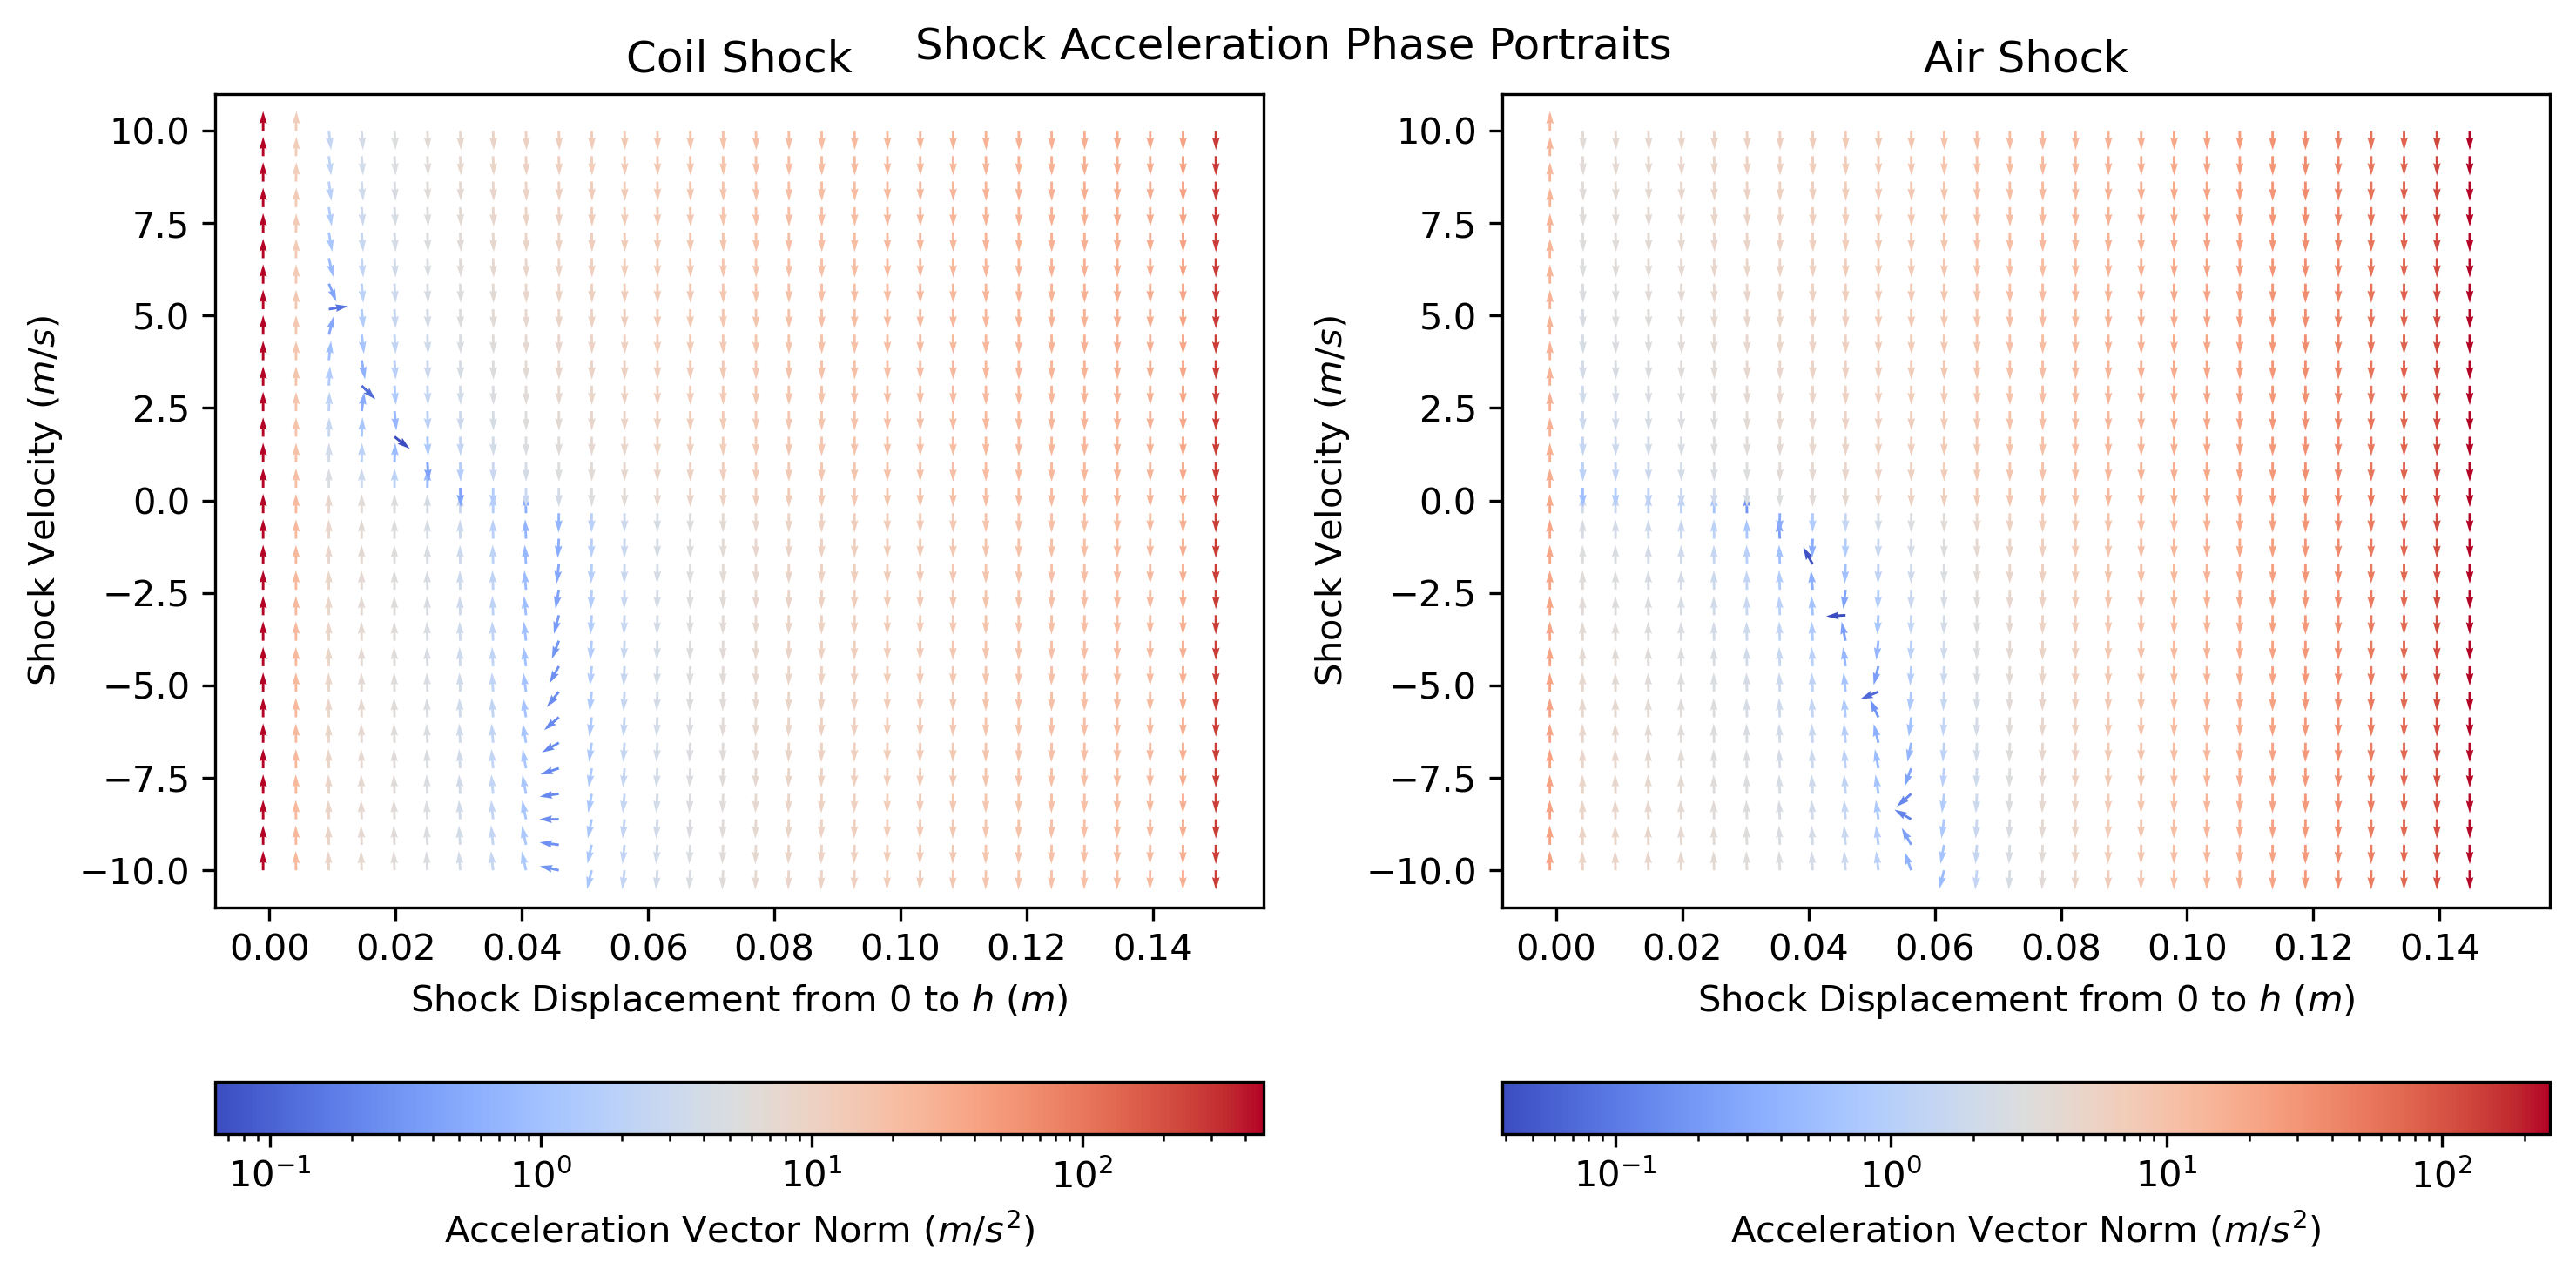

In [1097]:
from matplotlib.colors import LogNorm, Normalize

def plot_phase_portrait(shock, ax, title="", xlabel="", ylabel=""):
    y1 = np.linspace(-0.001, shock.travel_length, 30)
    y2 = np.linspace(-10, 10, 30)
    Y1, Y2 = np.meshgrid(y1, y2)

    # Compute the derivatives at each point on the grid
    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
    NI, NJ = Y1.shape
    for i in range(NI):
        for j in range(NJ):
            y = [Y1[i, j], Y2[i, j]]
            dydt = shock.model(0, y, lambda x : 0)
            u[i, j] = dydt[0] 
            v[i, j] = dydt[1] 

    norms = np.sqrt(u**2 + v**2)
    u = u / norms * 50#/ np.log(norms)
    v = v / norms * 50#/ np.log(norms)
    
    # Plot the phase portrait
    ax.quiver(Y1, Y2, u, v, norms, norm=LogNorm(), cmap="coolwarm")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.colorbar = plt.colorbar(ax.collections[0], ax=ax, orientation="horizontal", label=rf"Acceleration Vector Norm ($m/s^2$)")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_phase_portrait(evaluator1.shock, ax[0], title="Coil Shock", xlabel=rf"Shock Displacement from 0 to $h$ ($m$)", ylabel=rf"Shock Velocity ($m/s$)")
plot_phase_portrait(evaluator2.shock, ax[1], title="Air Shock", xlabel=rf"Shock Displacement from 0 to $h$ ($m$)", ylabel=rf"Shock Velocity ($m/s$)")
plt.tight_layout()
plt.suptitle("Shock Acceleration Phase Portraits")
plt.savefig("phase_portrait.pdf", format="pdf")
plt.show()

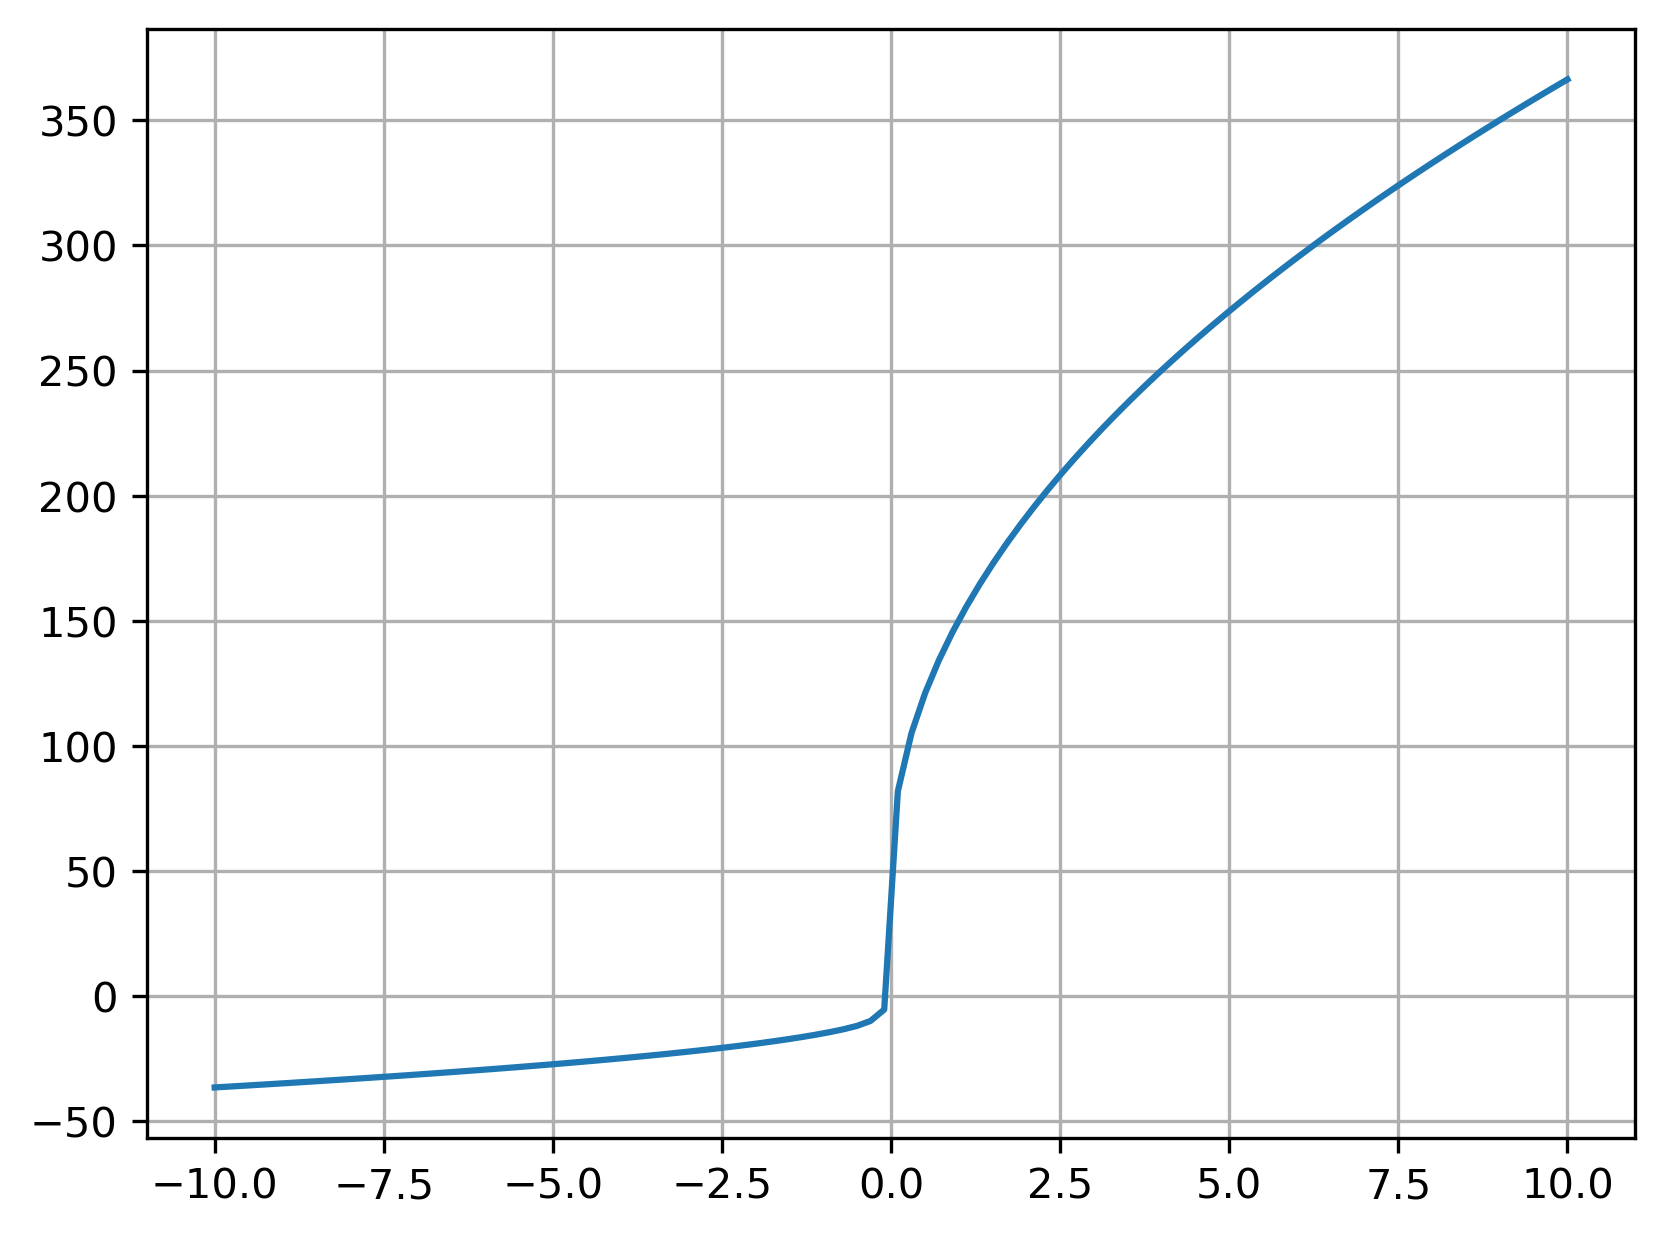

In [1098]:
shock = evaluator1.shock
xs = np.linspace(-10, 10, 100)
damping = [shock.damping(x) for x in xs]
plt.plot(xs, damping)
plt.grid()